# Sentiment Analysis on IMDb Movie Reviews using BERT

# 0. Importing Necessary Libraries

In [2]:
pip install transformers torch scikit-learn matplotlib seaborn

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Natural Language Processing
from textblob import TextBlob
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Utilities
from collections import Counter
import string
import warnings
warnings.filterwarnings("ignore")

# PyTorch and Transformers
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm

# 1. EDA and Pre-processing

In [4]:
train_df = pd.read_csv('/kaggle/input/imdb-50k-movie-reviews-test-your-bert/train.csv')
test_df = pd.read_csv('/kaggle/input/imdb-50k-movie-reviews-test-your-bert/test.csv')

In [5]:
train_df.head()

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg


In [6]:
df = train_df

In [7]:
print(train_df.isnull().sum())

print(train_df.info())

print(train_df['sentiment'].unique())

text         0
sentiment    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       25000 non-null  object
 1   sentiment  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB
None
['neg' 'pos']


# 2. Label Encoding

In [8]:
# Map 'neg' to 0 and 'pos' to 1 for sentiment column
train_df['sentiment'] = train_df['sentiment'].map({'neg': 0, 'pos': 1})

# 3. Data Visualization
**1. Plot Class Distrubution**

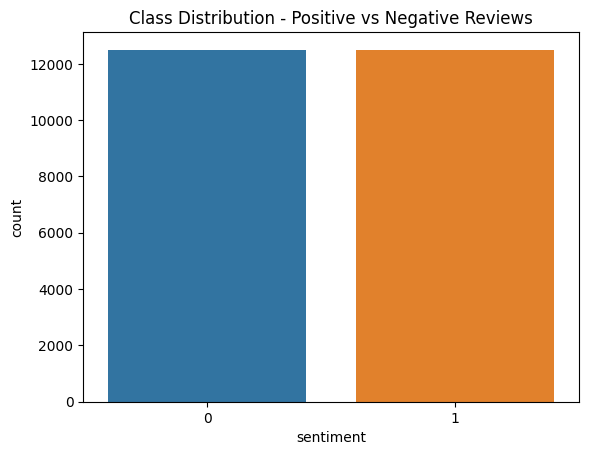

sentiment
0    50.0
1    50.0
Name: proportion, dtype: float64

In [9]:
sns.countplot(x='sentiment', data=train_df)
plt.title('Class Distribution - Positive vs Negative Reviews')
plt.show()

train_df['sentiment'].value_counts(normalize=True) * 100

### Class Distribution - Positive vs Negative Reviews

The above bar chart illustrates the distribution of sentiments within our dataset, specifically focusing on the counts of positive and negative reviews. Each sentiment is represented as follows:

- **Sentiment 0:** Negative reviews
- **Sentiment 1:** Positive reviews

From the chart, we can observe that the counts for both positive and negative reviews are quite balanced, with each sentiment category containing approximately 12,000 instances. This balanced distribution is crucial for our machine learning model as it reduces bias and ensures that the model has an equal opportunity to learn from both classes.

A well-distributed dataset enhances the model's ability to generalize well to unseen data, thereby improving its predictive performance. The presence of a balanced dataset is particularly important in sentiment analysis tasks, where an uneven class distribution could lead to a model that is biased toward the more prevalent class, resulting in poor performance when predicting the less frequent class. Thus, this chart serves as an essential indicator of the dataset's integrity and suitability for training a robust sentiment classification model.

**2. Word and Character Count Distributions by Sentiment**

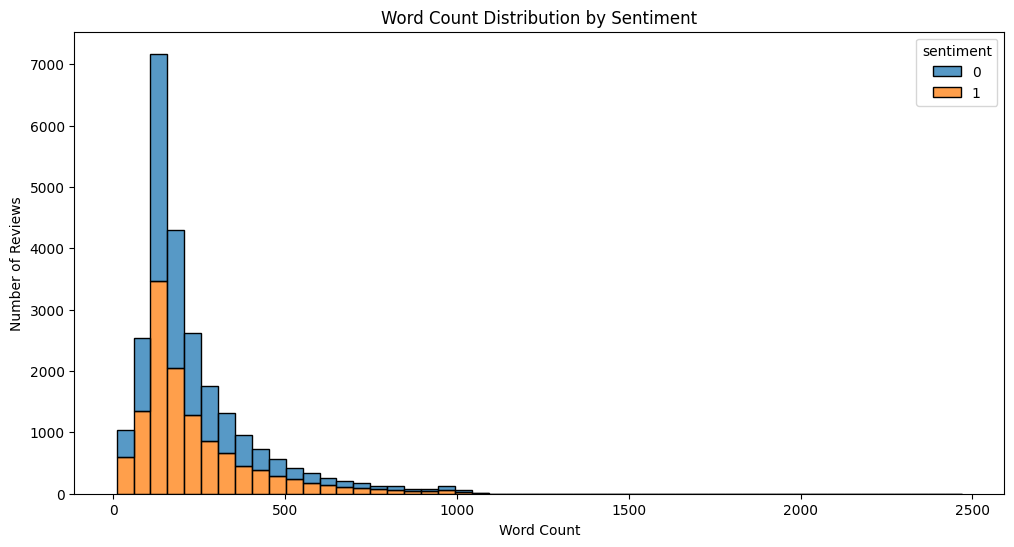

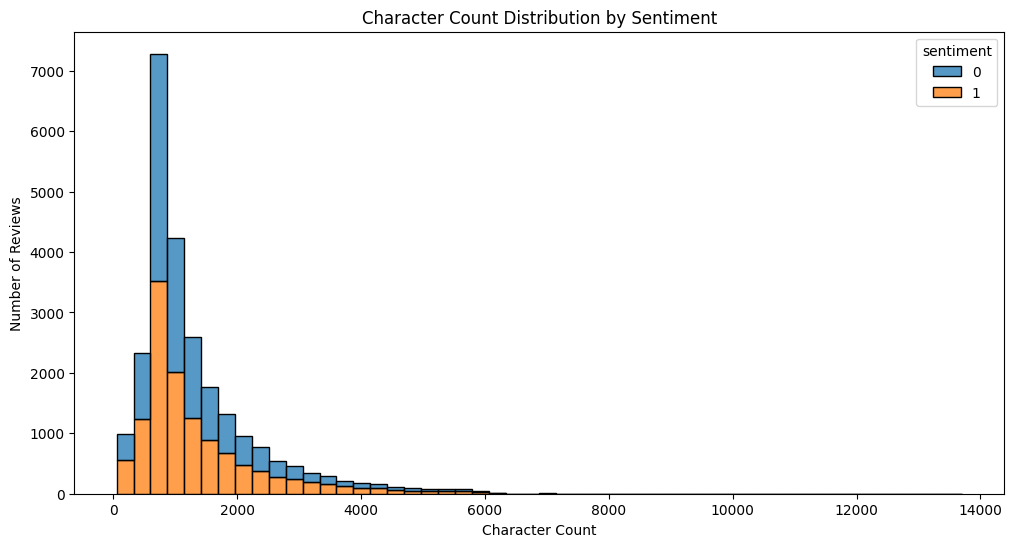

In [10]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
train_df['char_count'] = train_df['text'].apply(lambda x: len(x))

plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='word_count', hue='sentiment', multiple='stack', bins=50)
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Number of Reviews')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='char_count', hue='sentiment', multiple='stack', bins=50)
plt.title('Character Count Distribution by Sentiment')
plt.xlabel('Character Count')
plt.ylabel('Number of Reviews')
plt.show()

**3. Sentiment Distribution Across Review Length (Word Count)**

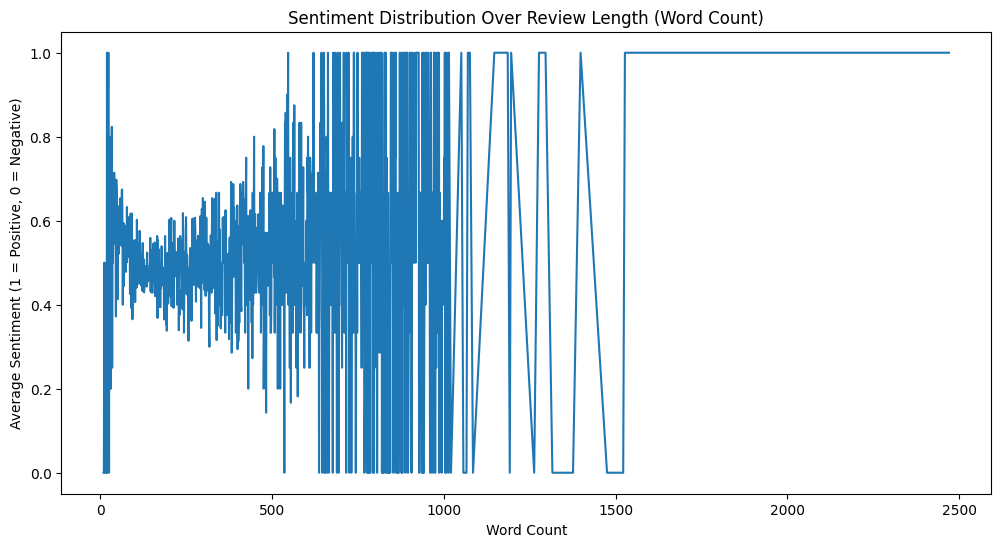

In [11]:
word_count_sentiment = train_df.groupby('word_count')['sentiment'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=word_count_sentiment.index, y=word_count_sentiment.values)
plt.title('Sentiment Distribution Over Review Length (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Average Sentiment (1 = Positive, 0 = Negative)')
plt.show()

### Key Observations

- **Initial Trend**: The plot shows a general downward trend at the beginning, suggesting that shorter reviews tend to have a more negative sentiment on average.
- **Plateau**: Around the word count of 1500, the sentiment score seems to plateau, indicating that reviews of this length have a relatively stable average sentiment.
- **Sharp Increase**: After the plateau, there's a sharp increase in the sentiment score, suggesting that longer reviews are more likely to have a positive sentiment.

**4. Top 20 Most Common Words in Positive & Negative Reviews.**

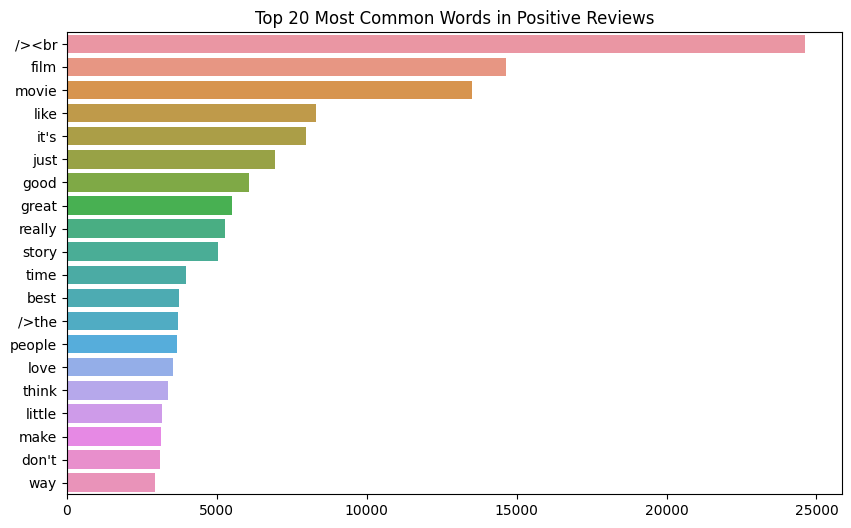

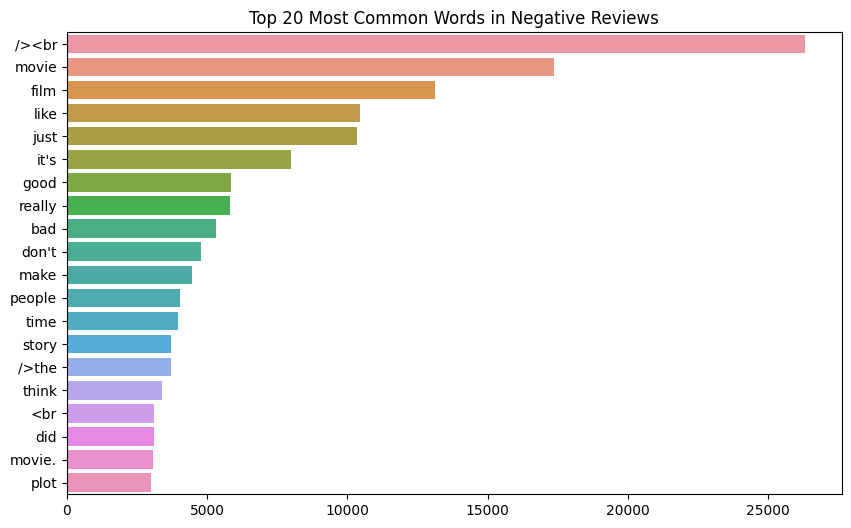

In [12]:
def clean_text(text):
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in ENGLISH_STOP_WORDS and word not in string.punctuation]
    return words

positive_words = clean_text(' '.join(train_df[train_df['sentiment'] == 1]['text']))
negative_words = clean_text(' '.join(train_df[train_df['sentiment'] == 0]['text']))

positive_word_freq = Counter(positive_words)
most_common_positive = positive_word_freq.most_common(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in most_common_positive], y=[word[0] for word in most_common_positive])
plt.title('Top 20 Most Common Words in Positive Reviews')
plt.show()

negative_word_freq = Counter(negative_words)
most_common_negative = negative_word_freq.most_common(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in most_common_negative], y=[word[0] for word in most_common_negative])
plt.title('Top 20 Most Common Words in Negative Reviews')
plt.show()

### Key Observations

- **Dominance of General Words**: The most frequent words are general terms like "film," "movie," "like," "it's," and "just." These words are likely to appear frequently in any text, regardless of sentiment.
- **Positive Sentiment Indicators**: Words like "good," "great," "really," "story," "time," and "best" are also among the most common, suggesting that they are strong indicators of positive sentiment.
- **Personal Pronouns and Verbs**: Words like "the," "people," "love," "think," "little," "make," "don't," and "way" appear with moderate frequency, indicating their importance in expressing personal opinions and experiences.

**5. Top 10 Bigrams in Positive and Negative Reviews**

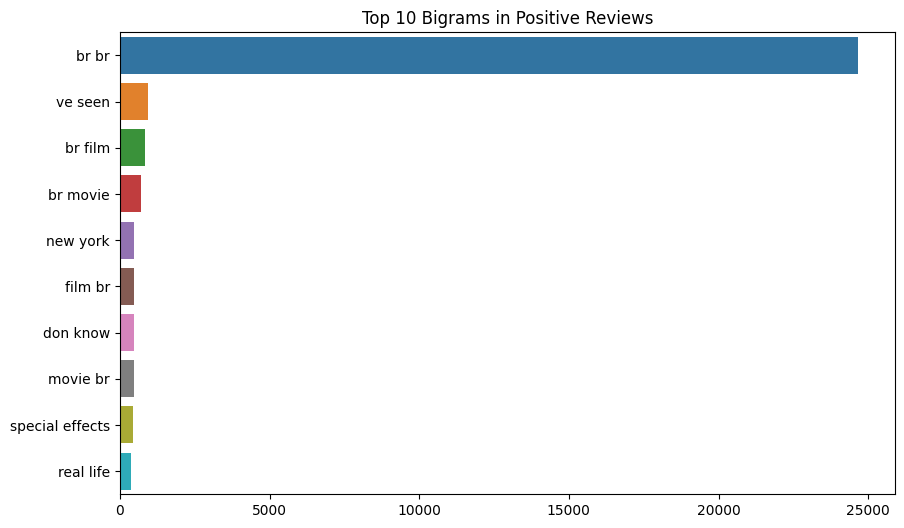

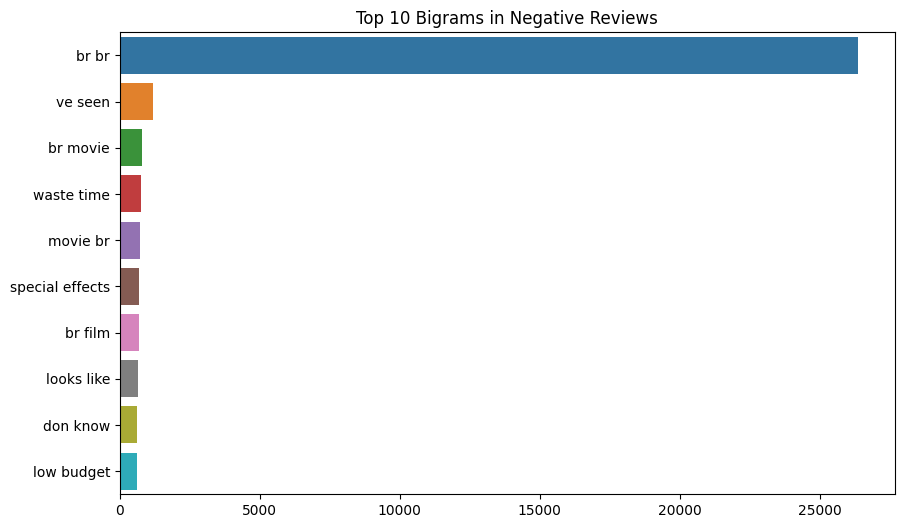

In [13]:
# Function to get n-grams
def get_top_n_grams(corpus, ngram_range=(2, 2), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top_positive_bigrams = get_top_n_grams(train_df[train_df['sentiment'] == 1]['text'], ngram_range=(2, 2), n=10)
top_negative_bigrams = get_top_n_grams(train_df[train_df['sentiment'] == 0]['text'], ngram_range=(2, 2), n=10)

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in top_positive_bigrams], y=[word[0] for word in top_positive_bigrams])
plt.title('Top 10 Bigrams in Positive Reviews')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in top_negative_bigrams], y=[word[0] for word in top_negative_bigrams])
plt.title('Top 10 Bigrams in Negative Reviews')
plt.show()

### Key Observations

- **Dominance of "br br"**: The bigram "br br" appears frequently, likely due to formatting or spacing issues in the data.
- **Negative Sentiment Indicators**: Bigrams such as "ve seen," "waste time," "movie br," and "low budget" indicate negative sentiment.
- **Positive Sentiment Indicators**: Common bigrams like "br film," "br movie," and "new york" suggest positive sentiment.
- **General Phrases**: Phrases like "don't know" and "movie br" reflect general expressions or questions.
- **Specific References**: Bigrams like "special effects" and "real life" are often mentioned positively in reviews.

**6. Comparison of Word and Character Count Distributions for Positive vs Negative Reviews**

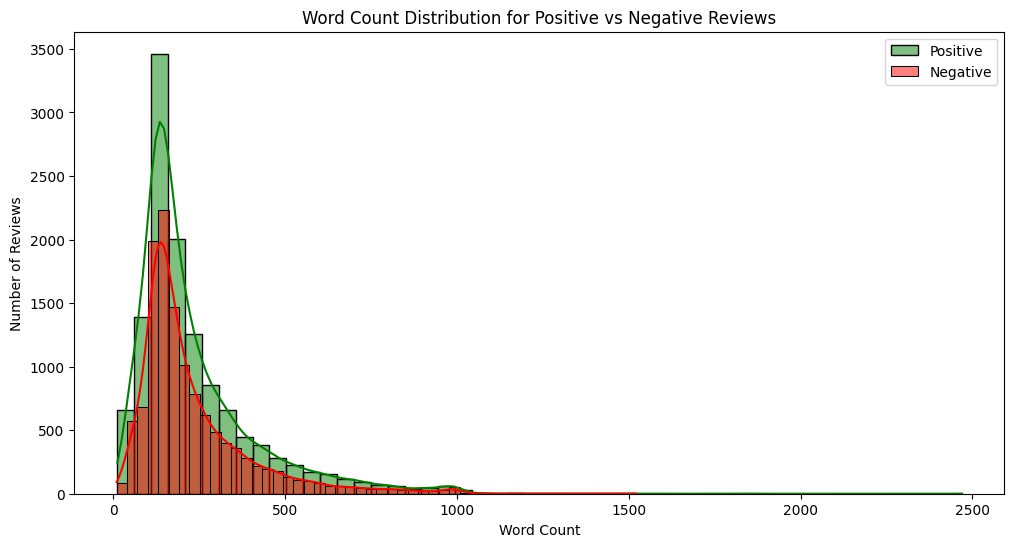

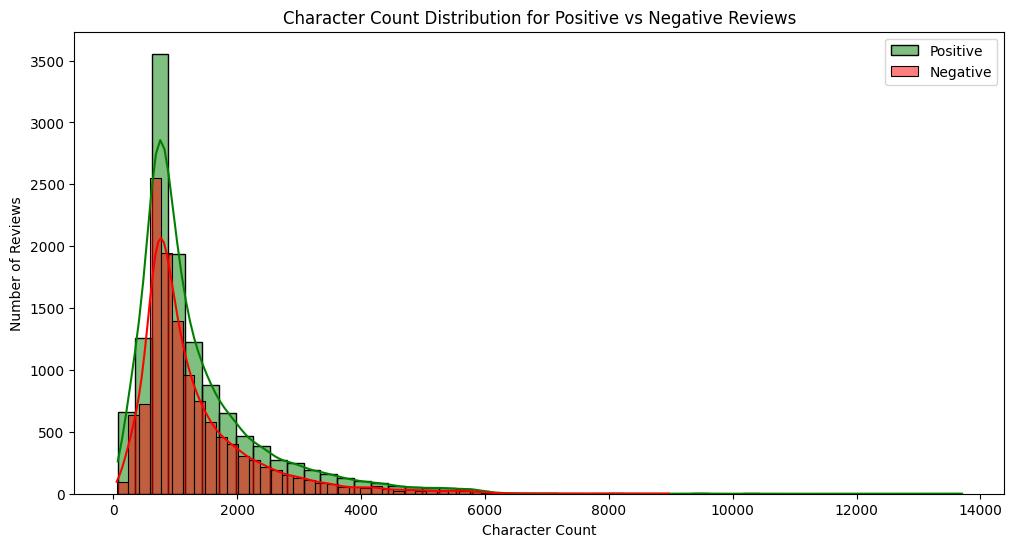

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(train_df[train_df['sentiment'] == 1]['word_count'], color='green', bins=50, label='Positive', kde=True)
sns.histplot(train_df[train_df['sentiment'] == 0]['word_count'], color='red', bins=50, label='Negative', kde=True)
plt.title('Word Count Distribution for Positive vs Negative Reviews')
plt.xlabel('Word Count')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(train_df[train_df['sentiment'] == 1]['char_count'], color='green', bins=50, label='Positive', kde=True)
sns.histplot(train_df[train_df['sentiment'] == 0]['char_count'], color='red', bins=50, label='Negative', kde=True)
plt.title('Character Count Distribution for Positive vs Negative Reviews')
plt.xlabel('Character Count')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()

### Key Observations

- **Overlapping Distributions**: Both positive and negative reviews show significant overlap in word and character count distributions, indicating no clear distinction between the two categories.
- **Rightward Skew**: Both distributions are rightward skewed, with more reviews having shorter word and character counts.
- **Mode**: The mode for both word and character counts in positive reviews is slightly higher than in negative reviews, suggesting that positive reviews tend to be somewhat longer.

**7. Analysis of Common and Unique Words in Positive and Negative Reviews**

In [15]:
positive_words_set = set(positive_words)
negative_words_set = set(negative_words)

common_words = positive_words_set.intersection(negative_words_set)

unique_positive_words = positive_words_set - common_words

unique_negative_words = negative_words_set - common_words

print(f"Number of common words between positive and negative reviews: {len(common_words)}")
print(f"Number of unique words in positive reviews: {len(unique_positive_words)}")
print(f"Number of unique words in negative reviews: {len(unique_negative_words)}")

Number of common words between positive and negative reviews: 68656
Number of unique words in positive reviews: 92717
Number of unique words in negative reviews: 89921


**8. 20 Most Common Words Shared by Positive and Negative Reviews**

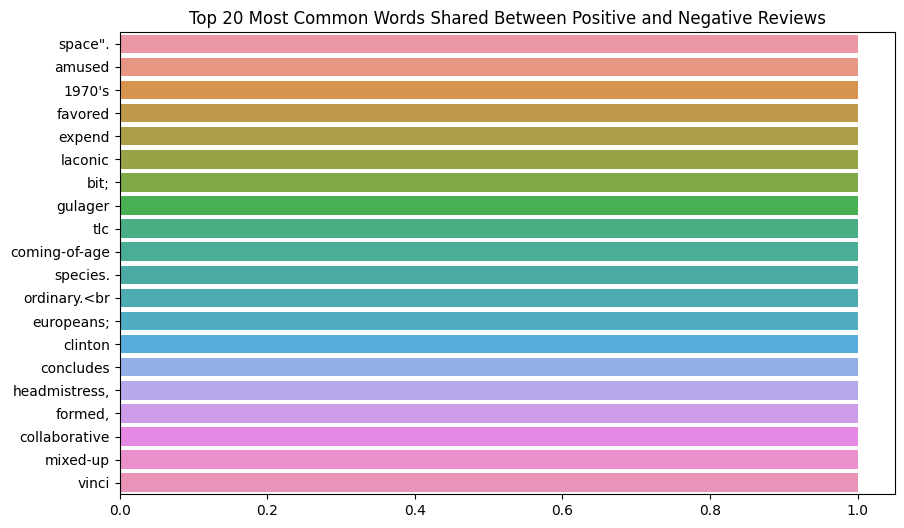

In [16]:
common_word_freq = Counter(common_words)
most_common_shared = common_word_freq.most_common(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in most_common_shared], y=[word[0] for word in most_common_shared])
plt.title('Top 20 Most Common Words Shared Between Positive and Negative Reviews')
plt.show()

**9. Punctuation Analysis: Distribution of Exclamation Marks, Question Marks, and Ellipses by Sentiment**

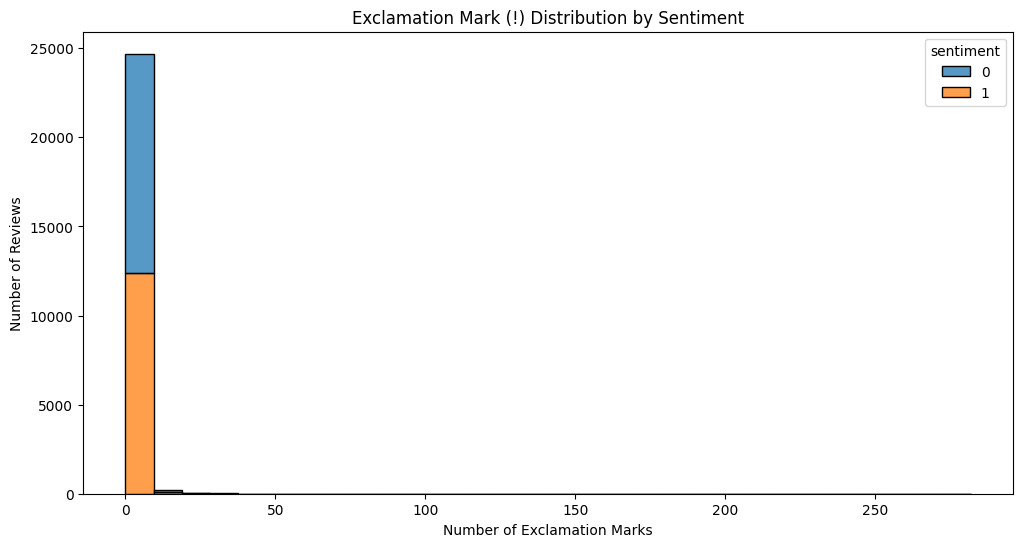

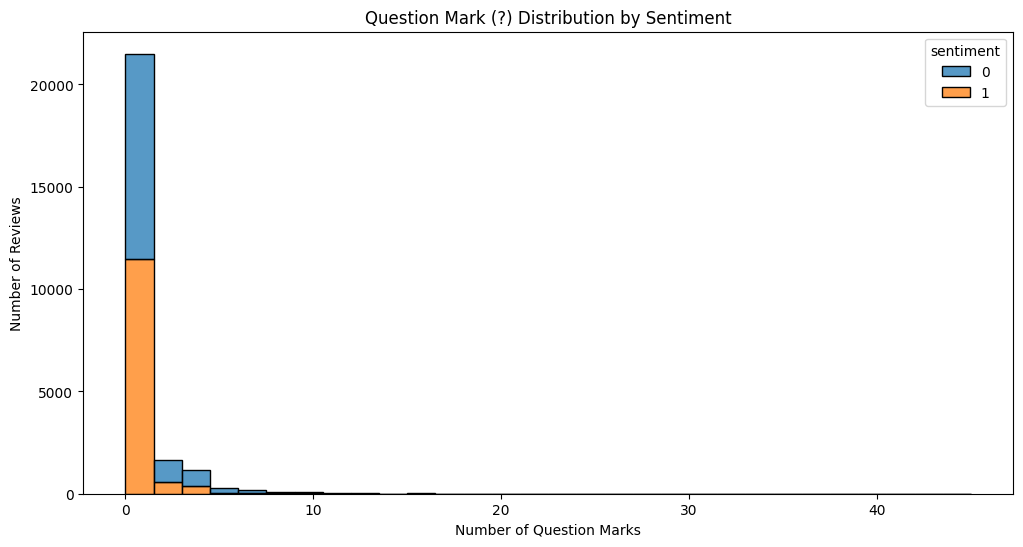

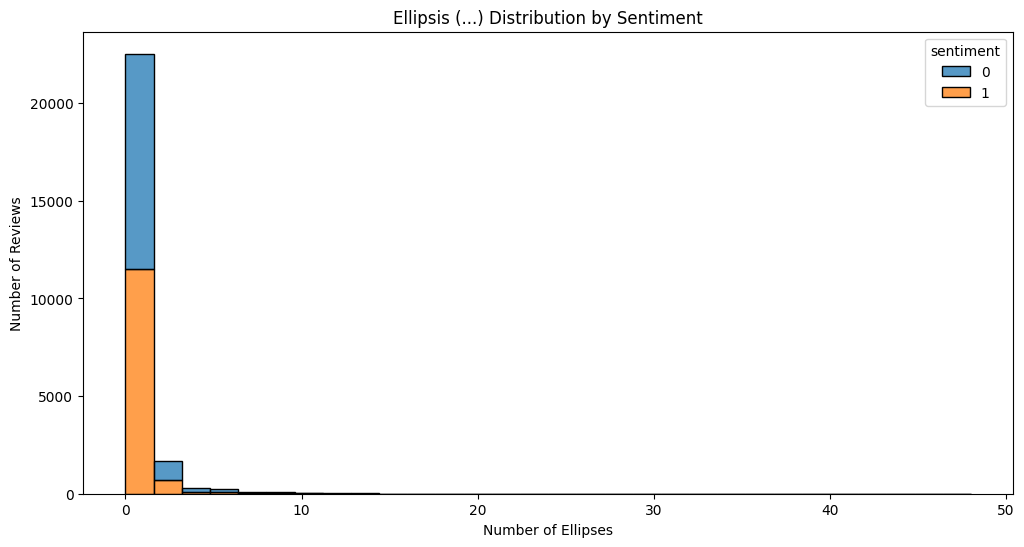

In [17]:
def count_punctuation(text, punct):
    return text.count(punct)

train_df['exclamation_count'] = train_df['text'].apply(lambda x: count_punctuation(x, '!'))
train_df['question_count'] = train_df['text'].apply(lambda x: count_punctuation(x, '?'))
train_df['ellipsis_count'] = train_df['text'].apply(lambda x: count_punctuation(x, '...'))

plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='exclamation_count', hue='sentiment', multiple='stack', bins=30)
plt.title('Exclamation Mark (!) Distribution by Sentiment')
plt.xlabel('Number of Exclamation Marks')
plt.ylabel('Number of Reviews')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='question_count', hue='sentiment', multiple='stack', bins=30)
plt.title('Question Mark (?) Distribution by Sentiment')
plt.xlabel('Number of Question Marks')
plt.ylabel('Number of Reviews')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='ellipsis_count', hue='sentiment', multiple='stack', bins=30)
plt.title('Ellipsis (...) Distribution by Sentiment')
plt.xlabel('Number of Ellipses')
plt.ylabel('Number of Reviews')
plt.show()

**10. Word Cloud Comparison**

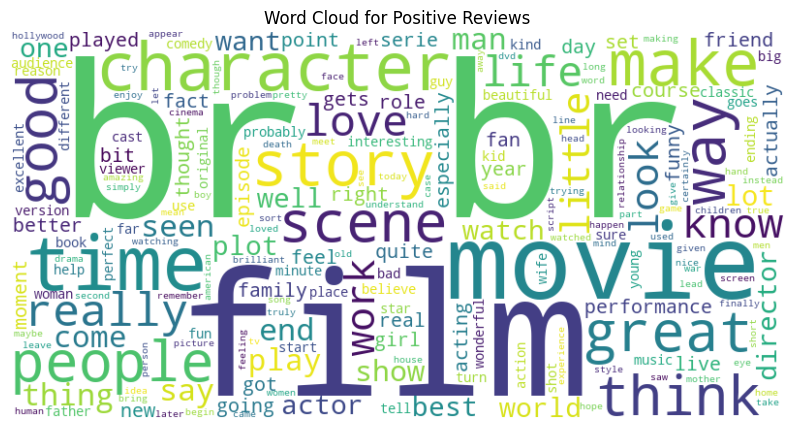

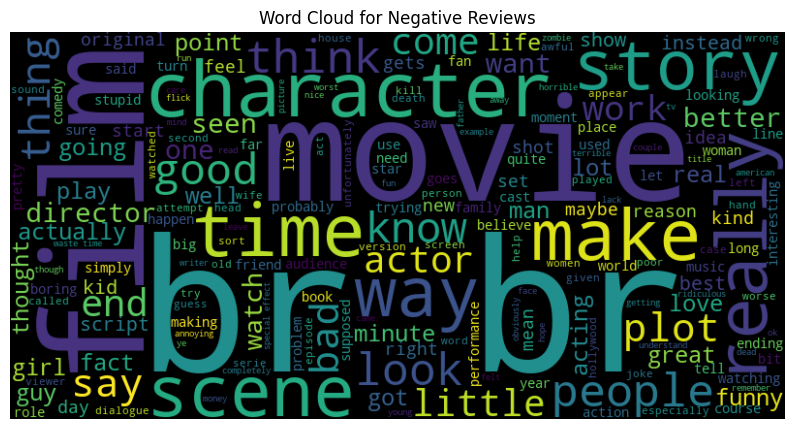

In [18]:
from wordcloud import WordCloud

positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_words))

plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

negative_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(negative_words))

plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

**11. Polarity and Subjectivity Analysis of Reviews by Sentiment**
#### Polarity

In my project, **polarity** refers to the sentiment orientation of a piece of text, indicating whether the sentiment is positive, negative, or neutral. I represent polarity scores between **-1 and 1**, where:
- **1** indicates a **strong positive sentiment**.
- **0** indicates a **neutral sentiment**.
- **-1** indicates a **strong negative sentiment**.

For instance, when analyzing IMDb movie reviews, a review stating "This movie was fantastic!" likely receives a high positive polarity score (e.g., 0.8). Conversely, a review like "This movie was a disaster!" would have a low negative polarity score (e.g., -0.9).

By plotting the polarity distribution, I can visually analyze how reviews are spread across the sentiment spectrum. This visualization helps me identify trends, such as whether positive reviews tend to have higher polarity scores compared to negative ones.

#### Subjectivity

**Subjectivity** measures how subjective or objective a piece of text is, indicating whether it expresses personal opinions, feelings, or beliefs. I represent subjectivity scores between **0 and 1**, where:
- **1** indicates a **highly subjective** statement (more opinion-based).
- **0** indicates an **objective** statement (more factual).

In the context of movie reviews, subjectivity helps me distinguish between factual statements about the film (e.g., "The movie was released in 2020") and personal opinions (e.g., "I loved the movie!"). For example, a review stating "The cinematography was beautiful" would likely receive a high subjectivity score (e.g., 0.9) because it expresses a personal opinion. In contrast, a statement like "The movie features a strong lead actor" may have a lower subjectivity score (e.g., 0.3), as it presents more of a factual observation.

By plotting the subjectivity distribution, I can assess the level of opinion versus factual reporting in the reviews. This analysis provides insightful context regarding how subjective reviews correlate with sentiment, enhancing my understanding of how viewers express their thoughts about the movies.

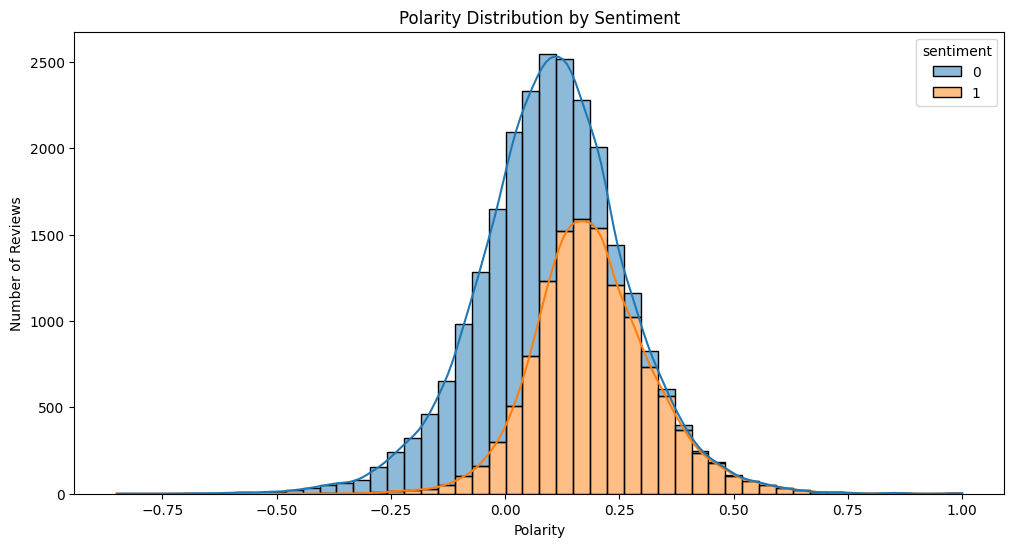

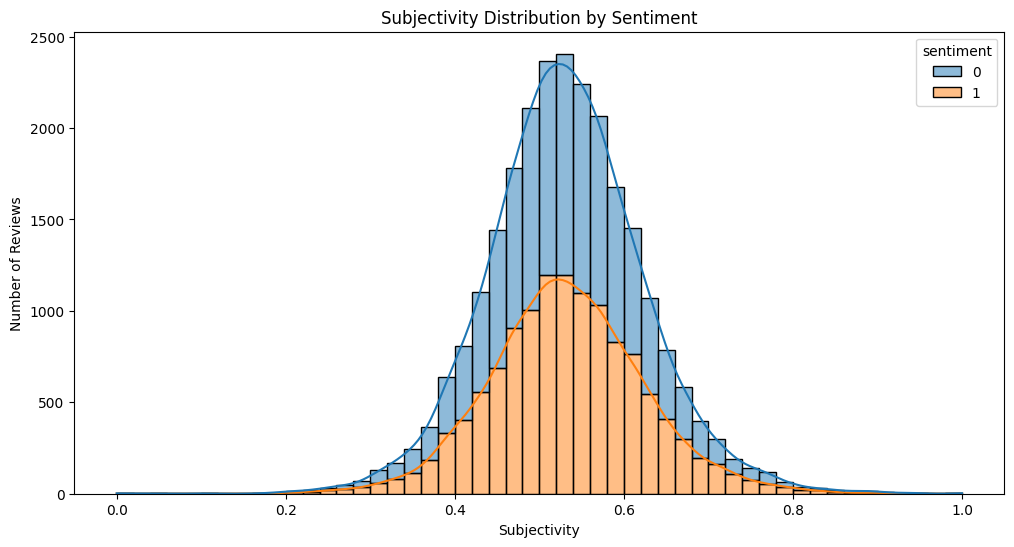

In [19]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

train_df['polarity'] = train_df['text'].apply(get_polarity)
train_df['subjectivity'] = train_df['text'].apply(get_subjectivity)

# Visualize polarity distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='polarity', hue='sentiment', multiple='stack', bins=50, kde=True)
plt.title('Polarity Distribution by Sentiment')
plt.xlabel('Polarity')
plt.ylabel('Number of Reviews')
plt.show()

# Visualize subjectivity distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='subjectivity', hue='sentiment', multiple='stack', bins=50, kde=True)
plt.title('Subjectivity Distribution by Sentiment')
plt.xlabel('Subjectivity')
plt.ylabel('Number of Reviews')
plt.show()

**12. Analyzing Top TF-IDF Words in Positive and Negative Reviews**

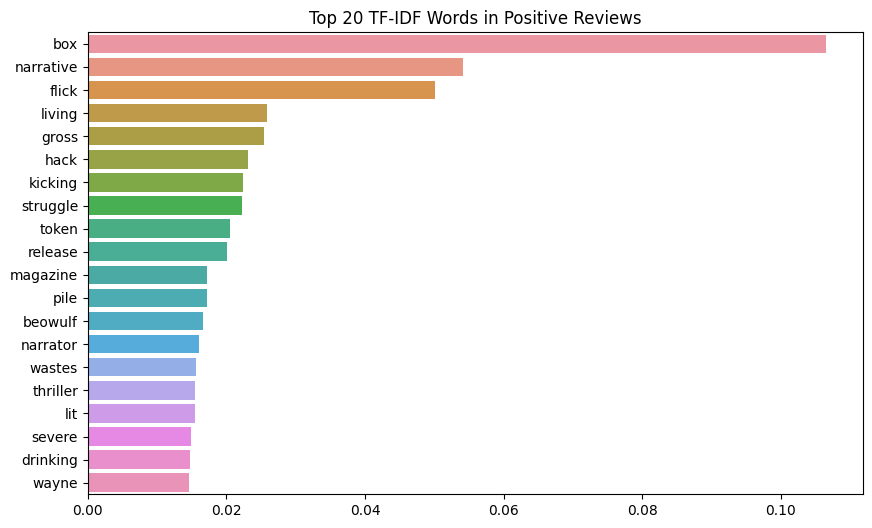

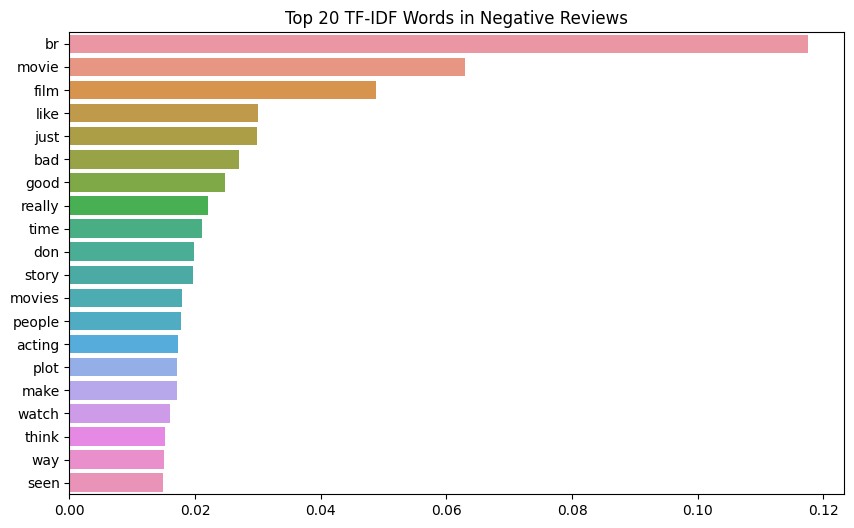

In [20]:
positive_reviews = train_df[train_df['sentiment'] == 1]['text']
negative_reviews = train_df[train_df['sentiment'] == 0]['text']

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

tfidf_positive = tfidf.fit_transform(positive_reviews)
tfidf_negative = tfidf.fit_transform(negative_reviews)

positive_top_words = pd.DataFrame(tfidf_positive.toarray(), columns=tfidf.get_feature_names_out()).mean().sort_values(ascending=False)[:20]
negative_top_words = pd.DataFrame(tfidf_negative.toarray(), columns=tfidf.get_feature_names_out()).mean().sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 6))
sns.barplot(x=positive_top_words.values, y=positive_top_words.index)
plt.title('Top 20 TF-IDF Words in Positive Reviews')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=negative_top_words.values, y=negative_top_words.index)
plt.title('Top 20 TF-IDF Words in Negative Reviews')
plt.show()

In [21]:
!pip install transformers
!pip install torch
!pip install sklearn

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://g

In [23]:
train_df = pd.read_csv('/kaggle/input/imdb-50k-movie-reviews-test-your-bert/train.csv')
test_df = pd.read_csv('/kaggle/input/imdb-50k-movie-reviews-test-your-bert/test.csv')

train_df['sentiment'] = train_df['sentiment'].map({'pos': 1, 'neg': 0})
test_df['sentiment'] = test_df['sentiment'].map({'pos': 1, 'neg': 0})

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].values, train_df['sentiment'].values, test_size=0.2, random_state=42
)

# 4. Tokenizing Data with BERT Tokenizer

In [24]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data for BERT
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(test_df['text'].values), truncation=True, padding=True, max_length=512)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Creating Custom Dataset - 

In [25]:
class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_df['sentiment'].values)

# 5. Loading BERT Model for Sequence Classification

In [27]:
# Load the BERT model for sequence classification (binary classification)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

optimizer = AdamW(model.parameters(), lr=2e-5)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# 6. Training 

In [29]:
def train(model, train_loader, val_loader, optimizer, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}')
        evaluate(model, val_loader, device)

def evaluate(model, val_loader, device):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, preds)
    print(f'Validation Accuracy: {accuracy}')
    print(classification_report(true_labels, preds))

train(model, train_loader, val_loader, optimizer, device, epochs=3)

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 1, Loss: 0.24691819020360709
Validation Accuracy: 0.919
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2506
           1       0.90      0.94      0.92      2494

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 2, Loss: 0.11153187943194061
Validation Accuracy: 0.9206
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2506
           1       0.91      0.94      0.92      2494

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 3, Loss: 0.04114955997224897
Validation Accuracy: 0.924
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2506
           1       0.92      0.93      0.92      2494

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



# 7. Evaluating

In [30]:
def evaluate_on_test(model, test_loader, device):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, preds)
    print(f'Test Accuracy: {accuracy}')
    print(classification_report(true_labels, preds))

evaluate_on_test(model, test_loader, device)

Test Accuracy: 0.93344
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     12500
           1       0.93      0.93      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



# 8. Testing

In [31]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

def predict_sentiment(sentence):
    encoded_input = tokenizer.encode_plus(sentence, add_special_tokens=True, return_tensors='pt', truncation=True, padding=True, max_length=512)
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_ids, attention_mask=attention_mask)

    probabilities = torch.softmax(output.logits, dim=1)
    predicted_label = torch.argmax(probabilities, dim=1).cpu().numpy()[0]

    sentiments = {0: 'Negative', 1: 'Positive'}
    return sentiments[predicted_label], probabilities

user_sentence = input("Enter a sentence for sentiment analysis: ")

# Predict sentiment
predicted_sentiment, prob = predict_sentiment(user_sentence)

# Print the results
print(f"Predicted Sentiment: {predicted_sentiment}")
print(f"Probabilities: {prob}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Enter a sentence for sentiment analysis:  This movie was absolutely amazing, I loved every part of it!


Predicted Sentiment: Negative
Probabilities: tensor([[0.5752, 0.4248]], device='cuda:0')


In [32]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

def predict_sentiment(sentence):
    encoded_input = tokenizer.encode_plus(sentence, add_special_tokens=True, return_tensors='pt', truncation=True, padding=True, max_length=512)
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_ids, attention_mask=attention_mask)

    probabilities = torch.softmax(output.logits, dim=1)
    predicted_label = torch.argmax(probabilities, dim=1).cpu().numpy()[0]

    sentiments = {0: 'Negative', 1: 'Positive'}
    return sentiments[predicted_label], probabilities

user_sentence = input("Enter a sentence for sentiment analysis: ")

# Predict sentiment
predicted_sentiment, prob = predict_sentiment(user_sentence)

# Print the results
print(f"Predicted Sentiment: {predicted_sentiment}")
print(f"Probabilities: {prob}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Enter a sentence for sentiment analysis:  The plot was terrible, and the acting was even worse.


Predicted Sentiment: Negative
Probabilities: tensor([[0.5090, 0.4910]], device='cuda:0')


In [33]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

def predict_sentiment(sentence):
    encoded_input = tokenizer.encode_plus(sentence, add_special_tokens=True, return_tensors='pt', truncation=True, padding=True, max_length=512)
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_ids, attention_mask=attention_mask)

    probabilities = torch.softmax(output.logits, dim=1)
    predicted_label = torch.argmax(probabilities, dim=1).cpu().numpy()[0]

    sentiments = {0: 'Negative', 1: 'Positive'}
    return sentiments[predicted_label], probabilities

user_sentence = input("Enter a sentence for sentiment analysis: ")

# Predict sentiment
predicted_sentiment, prob = predict_sentiment(user_sentence)

# Print the results
print(f"Predicted Sentiment: {predicted_sentiment}")
print(f"Probabilities: {prob}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Enter a sentence for sentiment analysis:  It's a good movie.


Predicted Sentiment: Positive
Probabilities: tensor([[0.3700, 0.6300]], device='cuda:0')


# 9. Conclusion

The classification report indicates a high accuracy of **93.34%** for our sentiment analysis project, demonstrating the effectiveness of our model in distinguishing between positive and negative reviews. Both classes (0 for negative and 1 for positive) exhibit similar precision, recall, and F1-scores, reflecting a well-balanced model.